In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set();

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
import shap

# Отбор признаков

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

In [3]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

# Значения Шепли

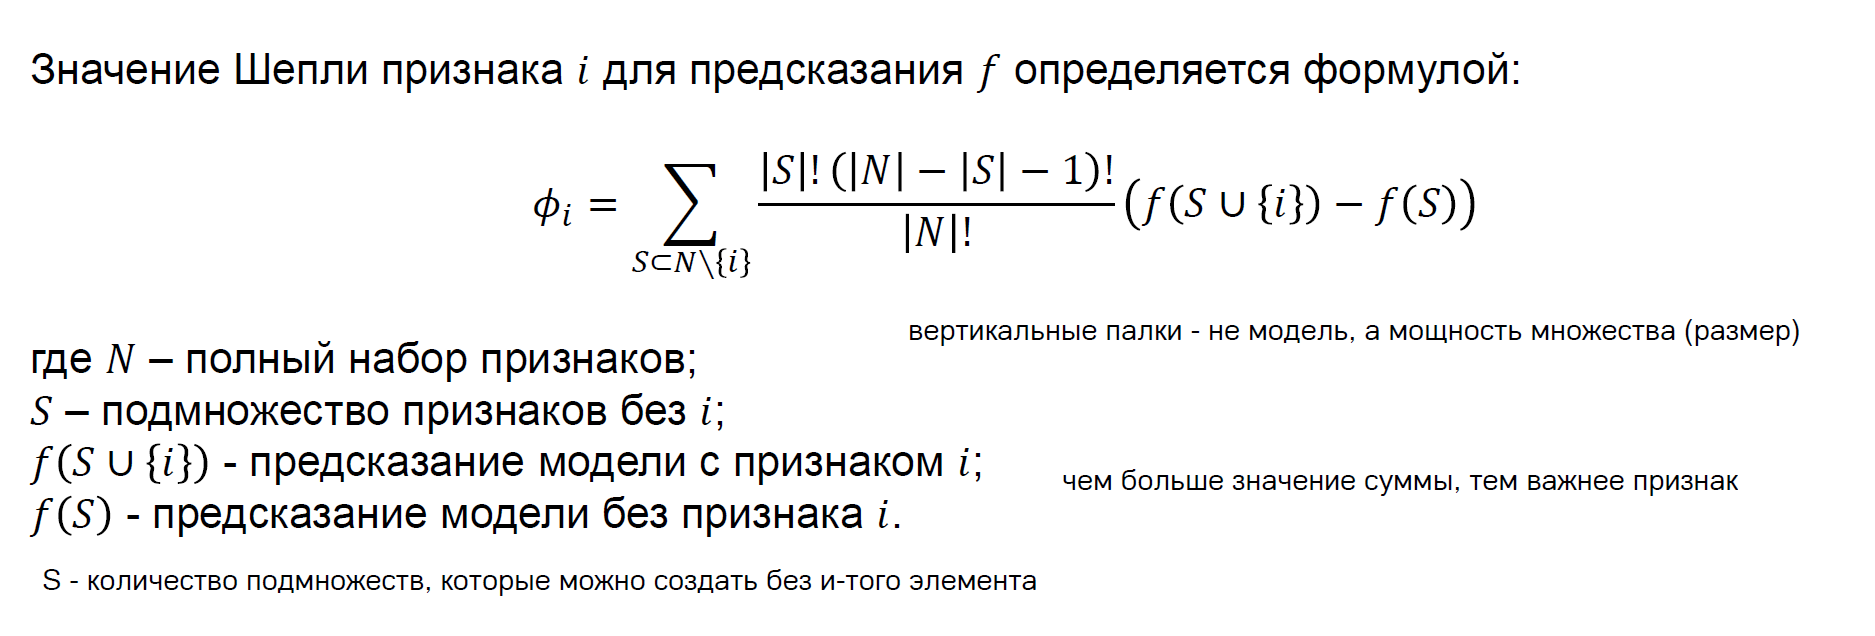

In [23]:
Image('Снимок экрана 2025-03-05 150829.png')

In [228]:
X_cut = X[X.columns[:5]]
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]
train_cut_X.head(1)

,back-suspension,battery-capacity,charge-time,compression,consumption-mixed
22607,3,-1.0,11636,9.5,-1.0


In [229]:
def subsets(S):
    sets = []
    len_S = len(S)
    for i in range(1<<len_S):
        subset = [S[bit] for bit in range(len_S) if i & (1<<bit)]
        sets.append(subset)

    return sets

In [230]:
def form_shep(data_X_cut, data_y):
    N = len(data_X_cut.columns)
    i_name = 0
    S = 0
    cols_names, fi_sum = [], []
#разделим данные
    train_X, test_X, train_y, test_y = train_test_split(data_X_cut, data_y, test_size=0.33, random_state=42)

    for i in range(len(data_X_cut.columns)):
        i_name = data_X_cut.columns[i]
        without_i_columns = data_X_cut.drop([i_name], axis=1).columns
        S = subsets(without_i_columns)[1:]

        fi_before_sum = []
        for subset in S:
            s_columns = list(subset)
            s_len = len(s_columns)
            
            #найдем MSE для S
            train_X_f_s = train_X[s_columns]
            test_X_f_s = test_X[s_columns]
            MSE_f_s = mean_squared_error(LinearRegression().fit(train_X_f_s, train_y).predict(test_X_f_s), test_y)

            #найдем MSE для S+i
            s_i_cols = list(subset) + [i_name]
            train_X_f_s_i = train_X[s_i_cols]
            test_X_f_s_i = test_X[s_i_cols]
            MSE_f_s_i = mean_squared_error(LinearRegression().fit(train_X_f_s_i, train_y).predict(test_X_f_s_i), test_y)

            #получим значения для каждого подмножества
            mse_diff = MSE_f_s - MSE_f_s_i
            weight = (math.factorial(s_len) * math.factorial(N - s_len - 1)) / math.factorial(N)
            fi_before_sum.append(weight * mse_diff)

        fi_sum.append(np.sum(fi_before_sum))
        cols_names.append(i_name)


#запихнем все в таблицу и отсортируем
    df = pd.DataFrame({
            'feature': cols_names,
            'fi_value': fi_sum,
            'sort': np.abs(fi_sum)
        })

    df_sorted = df.sort_values(by='sort', ascending=False).reset_index(drop=True).drop(columns='sort', axis=1)
    
    return df_sorted

In [231]:
form_shep(X_cut, y)

,feature,fi_value
0,back-suspension,765.913835
1,consumption-mixed,442.660705
2,charge-time,339.349596
3,battery-capacity,55.011674
4,compression,0.018004


# Пермутационная важность

In [181]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [182]:
mse_all = mean_squared_error(LinearRegression().fit(train_X, train_y).predict(test_X), test_y)
mse_all

31015.75310911931

In [208]:
def importance(data_X, data_y):
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.33, random_state=42)
    mse_all_before = mean_squared_error(LinearRegression().fit(train_X, train_y).predict(test_X), test_y)

    
    important = {}

    new_test = test_X.copy()
    for i in new_test.columns:
        new_test[i] = np.random.permutation(new_test[i].values)

        mse_after = mean_squared_error(LinearRegression().fit(train_X, train_y).predict(new_test), test_y)

        important[i].append(mse_after - mse_all_before)

    df = pd.DataFrame({
            'feature': important.keys(),
            'importance': important.values()
        }).sort_values(by='importance', ascending=True).reset_index(drop=True)
    return df        # Перемешиваем только текущий признак

In [226]:
def importance(data_X, data_y):
    # Разделяем данные
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.33, random_state=42)
    model = LinearRegression().fit(train_X, train_y)
    mse_all_before = mean_squared_error(test_y, model.predict(test_X))
    
    importance = {}
    
    for i in test_X.columns:
        test_new = test_X.copy()
        test_new[i] = np.random.permutation(test_new[i].values)

        mse_after = mean_squared_error(test_y, model.predict(test_new))

        importance[i] = mse_after - mse_all_before
    
    # Создаем DataFrame и сортируем
    df = pd.DataFrame({
        'feature': importance.keys(),
        'importance': importance.values()
    }).sort_values(by='importance', ascending=True).reset_index(drop=True)
    
    return df

In [227]:
importance(X, y)

,feature,importance
0,cylinders-order,-11.702988
1,back-suspension,-0.025623
2,models_group,0.426604
3,supply-system,3.016336
4,models_male,5.420213
5,valvetrain,26.626640
6,configurations_safety-rating,32.509168
7,consumption-mixed,32.620720
8,power-electro-kw,50.080904
9,luxury,109.046155
